## In this study, we not only change latent variable so it is close to mixture, but we also modify mixture

In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle
from vae_lib.preprocessing.load_mnist import load_mnist
from vae_lib.preprocessing.data_permutation import permute
from vae_lib.graphics.plot_utils import plot_2d_latent_space
from vae_lib.utils.nn_logger import get_log_folder
from vae_lib.nn.dense_layer import DenseLayer
from vae_lib.nn.stochastic_nn_with_gmm import StochasticNNWithGmm

In [2]:
Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

### Utility functions

In [3]:
# def permute(X, y=None):
#     n_all_cases = X.shape[0]
#     perm = np.arange(n_all_cases)
#     np.random.shuffle(perm)
#     if y is not None:
#         return X[perm], y[perm]
#     else:
#         return X[perm], None

In [4]:
def plot_latent_space(model, onehot_encoder, X, y):
    m, sd = model.encode2(X)
    m_flat = m.reshape(-1)
    sd_flat = sd.reshape(-1)
    y_decoded = onehot_encoder.inverse_transform(y).reshape(-1)
    plt.figure(figsize=(10, 10))
    plt.scatter(m_flat, sd_flat, c=y_decoded, cmap='brg')
    plt.colorbar()
    plt.show()

In [5]:
# def plot_2d_latent_space(model, onehot_encoder, X, y):
#     m, sd = model.encode2(X_test)
#     y_decoded = onehot_encoder.inverse_transform(y_test).reshape(-1)
#     fig = plt.figure(figsize=(20, 20))


#     plt.subplot(2, 2, 1)
#     plt.scatter(m[:,0], m[:,1], c=y_decoded, cmap='brg')
#     plt.colorbar()

#     plt.subplot(2, 2, 2)
#     plt.scatter(sd[:,0], sd[:,1], c=y_decoded, cmap='brg')
#     plt.colorbar()

#     plt.subplot(2, 2, 3)
#     plt.scatter(m[:,0], sd[:,0], c=y_decoded, cmap='brg')
#     plt.colorbar()

#     Z = np.random.normal(m,sd)
#     plt.subplot(2, 2, 4)
#     plt.scatter(Z[:,0], Z[:,1], c=y_decoded, cmap='brg')
#     plt.colorbar()

#     plt.show()

### Import MNIST

In [6]:
#mnist = tf.keras.datasets.mnist

### Load data

In [7]:
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [8]:
#X = np.concatenate((X_train, X_test), axis=0)

In [9]:
#n_all_cases = X.shape[0]
#input_dim = X.shape[1]

In [10]:
#X = np.reshape(X, (n_all_cases, -1))
#y = np.concatenate((y_train, y_test)).astype('float32')

In [11]:
#label_reshaped = y.reshape(len(y), 1)
#onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
#onehot_encoded = onehot_encoder.fit_transform(label_reshaped)

In [12]:
#n_classes = onehot_encoded.shape[1]

In [13]:
#X = (X > 0.5).astype(np.float32)

In [14]:
#X_perm, onehot_encoded_perm = permute(X,onehot_encoded)

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X_perm, onehot_encoded_perm, test_size=0.1, random_state=40)

In [16]:
X_train, X_test, y_train, y_test, onehot_encoder = load_mnist()

### Utility functions

In [17]:
# def get_log_folder():
#     now = datetime.datetime.now()
#     day_of_the_year=now.strftime("%d_%m_%Y")
#     suff = now.strftime("%Y%m%d%H%M%S")
#     #print(now.strftime("%Y%m%d%H%M%S"))
#     log_folder = "/tmp/class_vae/deep/{}/{}".format(day_of_the_year,suff)
#     return log_folder

In [18]:
# def calculate_accuracy_np(y_pred, y_true):
#     predicted_class = np.argmax(y_pred, axis=1)
#     true_class = np.argmax(y_true, axis=1)
#     cond_correct = predicted_class == true_class
#     return np.mean(cond_correct.astype(int))

In [19]:
def accuracy_for_score(y_pred, y_true, score, threshold):
    cond = score > threshold
    accuracy = calculate_accuracy_np(y_pred[cond], y_true[cond])
    return accuracy

In [20]:
def classification_ratio(score, threshold):
    cond = score > threshold
    above_threshold = np.mean((score > threshold).astype(int))
    return above_threshold

### Build neural network

In [21]:
# class DenseLayer:

#     def __init__(self, in_dim, out_dim, f=tf.nn.relu, name="dense"):
#         self.name = name
#         with tf.name_scope(self.name):
#             self.f = f
#             initializer = tf.contrib.layers.xavier_initializer()
#             self.W = tf.Variable(initializer((in_dim, out_dim)), name="W")
#             self.b = tf.Variable(tf.constant(0.1, shape=[out_dim]), name="bias")
#             tf.summary.histogram("weights", self.W)
#             tf.summary.histogram("bias", self.b)

#     def forward(self, X):
#         with tf.name_scope(self.name):
#             act = self.f(tf.matmul(X, self.W) + self.b)
#             tf.summary.histogram("activation", act)
#             return act

In [22]:
# class VClassifier:

#     def encode(self, X, middle_layer_dim):
#         current_value = X
#         for layer in self.encoder_layers:
#             current_value = layer.forward(current_value)

#         means = current_value[:, :middle_layer_dim]
#         tmp = current_value[:, middle_layer_dim:]
# #         stdevs = tf.sqrt(tf.exp(tmp))
#         stdevs = tf.nn.softplus(tmp) + 1e-6
        
        
#         return means, stdevs
    
#     def create_encoder(self, X, input_dim, hidden_dims):
        
#         in_dim = input_dim
#         for h_dim in hidden_dims[:-1]:
#             h = DenseLayer(in_dim, h_dim)
#             self.encoder_layers.append(h)
#             in_dim = h_dim

#         middle_layer_dim = hidden_dims[-1]
#         self.encoder_layers.append(DenseLayer(in_dim, 2 * middle_layer_dim, f=lambda x: x))

#         return self.encode(X, middle_layer_dim)
    
#     def decode(self, Z, output_dim, hidden_dims):
#         decoder_layers = []

#         in_dim = hidden_dims[-1]
#         for hidden_dim in reversed(hidden_dims[:-1]):
#             h = DenseLayer(in_dim, hidden_dim)
#             decoder_layers.append(h)
#             in_dim = hidden_dim

#         decoder_layers.append(DenseLayer(in_dim, output_dim, f=lambda x: x))

#         current_value = Z
#         for decoder_layer in decoder_layers:
#             current_value = decoder_layer.forward(current_value)

#         return current_value
    
#     def calculateKL(self, mean, std):
#         inner = 1 + tf.math.log(1e-8 + std ** 2) - mean ** 2 - std ** 2
#         kls = 0.5 * tf.math.reduce_sum(inner, axis=1)
#         return tf.math.reduce_mean(kls)
    
#     def create_accuracy_node(self, y_true, y_pred):
#         correct_mask_node = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
#         accuracy_node = tf.reduce_mean(tf.cast(correct_mask_node, tf.float32))
#         return accuracy_node

#     def __init__(self, x_dim, y_dim, hidden_dims, log_folder, alpha, beta, gamma, omega, r):
#         self.encoder_layers = []
#         self.x_dim = x_dim
#         self.y_dim = y_dim
#         self.layer = 1
#         self.cum_thetas = []
        
#         tf.reset_default_graph()
#         self.X = tf.placeholder(tf.float32, shape=(None, x_dim), name="x")
#         self.y = tf.placeholder(tf.float32, shape=(None, y_dim), name="y")
        
#         init_cov = np.array([
#             [0.07,0.0],
#             [0.0,0.007]
#         ], dtype="float64")
#         init_angles = [(2*i*np.pi)/10 for i in range(10)]
# #         thetas = tf.get_variable(initializer=init_angles, name="thetas")
#         thetas = tf.get_variable(initializer=init_angles, name="thetas")
#         tf.summary.histogram("thetas", thetas)

#         self.d_gmm = DynamicGmmOnCircle(tf.unstack(thetas), init_cov, r=1)
        
        
#         #self.mix = MixtureOfNormalsOnCircle(10, r=r)

#         #encoder
#         self.means, self.stdevs = self.create_encoder(self.X, x_dim, hidden_dims)

#         n = Normal(
#           loc=self.means,
#           scale=self.stdevs,
#         )
#         self.Z = n.sample()

#         print("Hidden shape: {}".format(self.Z.shape))

#         #decoder
#         self.logits = self.decode(self.Z, (x_dim+y_dim), hidden_dims)

#         self.XY_hat_distribution = Bernoulli(logits=self.logits)

#         self.posterior_predictive_probs = tf.nn.sigmoid(self.logits)
#         self.score = tf.norm(self.means, axis=1)
        
#         if y_dim > 0:
#             self.posterior_predictive_probs_y = self.posterior_predictive_probs[:,x_dim:(x_dim+y_dim)]
#             print("self.posterior_predictive_probs_y.shape {}".format(self.posterior_predictive_probs_y.get_shape().as_list()))
#             print("self.y.shape {}".format(self.y.get_shape().as_list()))
#             self.accuracy_node = self.create_accuracy_node(self.y, self.posterior_predictive_probs_y)
#             tf.summary.scalar("accuracy", self.accuracy_node)

#         with tf.name_scope('COST'):
            
#             if y_dim > 0:
#                 xy = tf.concat([self.X, self.y], axis=1)
#             else:
#                 xy = self.X
#             print("xy.shape {}".format(xy.get_shape().as_list()))

#             expected_log_likelihood_2 = -tf.reduce_sum(
#                 tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=self.logits[:,0:x_dim]), 
#                 axis=1
#             )

#             kl = self.calculateKL(self.means, self.stdevs)
#             tf.summary.scalar("KL", kl)

#             gmm_cost = self.d_gmm.penalty_term_with_gd_only_tf(self.Z)
# #             gmm_cost = self.penalty_term_with_gd_only_tf(self.Z, tf.unstack(self.thetas), self.init_cov,r=1)
# #             gmm_cost = self.penalty_term_with_gd_only_tf(self.Z, tf.unstack(self.thetas), self.init_cov)
#             tf.summary.scalar("gmm_cost", gmm_cost)
            
#             exp_loglik_2 = tf.reduce_mean(expected_log_likelihood_2)
#             tf.summary.scalar("loglik_2", exp_loglik_2)
            
#             if y_dim > 0:
#                 cross_entropy_classifier = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits[:,x_dim:(x_dim+y_dim)])
#                 avg_cross_entropy_classifier = -tf.reduce_mean(cross_entropy_classifier)
#                 tf.summary.scalar("softmax_cross_entropy", avg_cross_entropy_classifier)
#                 elbo = alpha * exp_loglik_2 + beta * kl + gamma * avg_cross_entropy_classifier - omega*gmm_cost
#             else:
#                 elbo = alpha * exp_loglik_2 + beta * kl
                
#             tf.summary.scalar("ELBO", elbo)
            
        
#         self.train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(-elbo)
#         #self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-elbo)

#         self.init_op = tf.global_variables_initializer()
            
#         #InteractiveSession.close()
#         self.sess = tf.InteractiveSession()
#         self.sess.run(self.init_op)

#         self.merged_summary = tf.summary.merge_all()

#         self.writer_train = tf.summary.FileWriter(log_folder)
#         self.writer_train.add_graph(self.sess.graph)

#     def fit(self, X_train, y_train, epochs=30, batch_sz=64):
#         #costs=[]
#         n_batches = len(X_train) // batch_sz
#         print("n_batches:", n_batches)

        
#         iteration = 1
#         for i in range(epochs):
#             print("epoch: %d" % i)
#             #np.random.shuffle(X_train)
#             X_train, y_train = permute(X_train, y_train)
#             for j in range(n_batches):
#                 batch_x = X_train[j * batch_sz:(j + 1) * batch_sz]
                
#                 if self.y_dim > 0:
#                     batch_y = y_train[j * batch_sz:(j + 1) * batch_sz]
#                     self.sess.run(self.train_op, feed_dict={self.X: batch_x, self.y: batch_y})
#                     if j % 100 == 0:
#                         s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x, self.y: batch_y})
#                         self.writer_train.add_summary(s, iteration)
                        
#                         tf_thetas = self.sess.run(self.d_gmm.thetas, feed_dict={self.X: batch_x, self.y: batch_y})
#                         self.cum_thetas.append(tf_thetas)
#                 else:
#                     self.sess.run(self.train_op, feed_dict={self.X: batch_x})
#                     if j % 100 == 0:
#                         s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x})
#                         self.writer_train.add_summary(s, iteration)
                    
#                 iteration += 1
            
#             if self.y_dim > 0:
#                 train_accuracy = self.calculate_accuracy(X_train, y_train)
#                 print("Train accuracy {}".format(train_accuracy))

#         # plt.plot(costs)
#         # plt.show()
        
#     def calculate_accuracy(self, X, y):
#         accuracy = self.sess.run(self.accuracy_node, feed_dict={self.X: X, self.y: y})
#         return accuracy
        
#     def predict(self, X):
#         y_pred = self.sess.run([self.posterior_predictive_probs_y, self.score], feed_dict={self.X: X})
#         return y_pred

# #     def predict_probs(self, X):
# #         return self.sess.run(self.posterior_predictive_probs, feed_dict={self.X: X})
    
#     def encode2(self, X):
#         means, stdevs = self.sess.run([self.means, self.stdevs], feed_dict={self.X: X})
#         return means, stdevs
    
#     def encode_to_discrete(self, X):
#         responsibilities = self.sess.run(self.resp, feed_dict={self.X: X})
#         return responsibilities
    
#     def sampleLatent(self, X):
#         Z = self.sess.run(self.Z, feed_dict={self.X: X})
#         return Z
    
#     def get_cum_thetas(self):
#         return self.cum_thetas

In [23]:
init_cov = np.array([
    [0.7,0.0],
    [0.0,0.07]
], dtype="float64")

### Supervised VAE

In [25]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = StochasticNNWithGmm(
    x_dim=X_train.shape[1], 
    y_dim=y_train.shape[1], 
    hidden_dims=[512, 256, 128, 2], 
    log_folder=log_folder,
    alpha=0,
    beta=0,
    gamma=1,
    omega=0.00005,
    r=0.8,
    K=10,
    init_cov=init_cov,
    is_latent_supervised=True
)
model_supervised.fit(X_train, y_train, X_test, y_test, epochs=10, log_interval=100)

test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
print("Test accuracy {}".format(test_acc))


Starting autoencoder. Log folder=/tmp/class_vae/deep/24_04_2019/20190424164725
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp

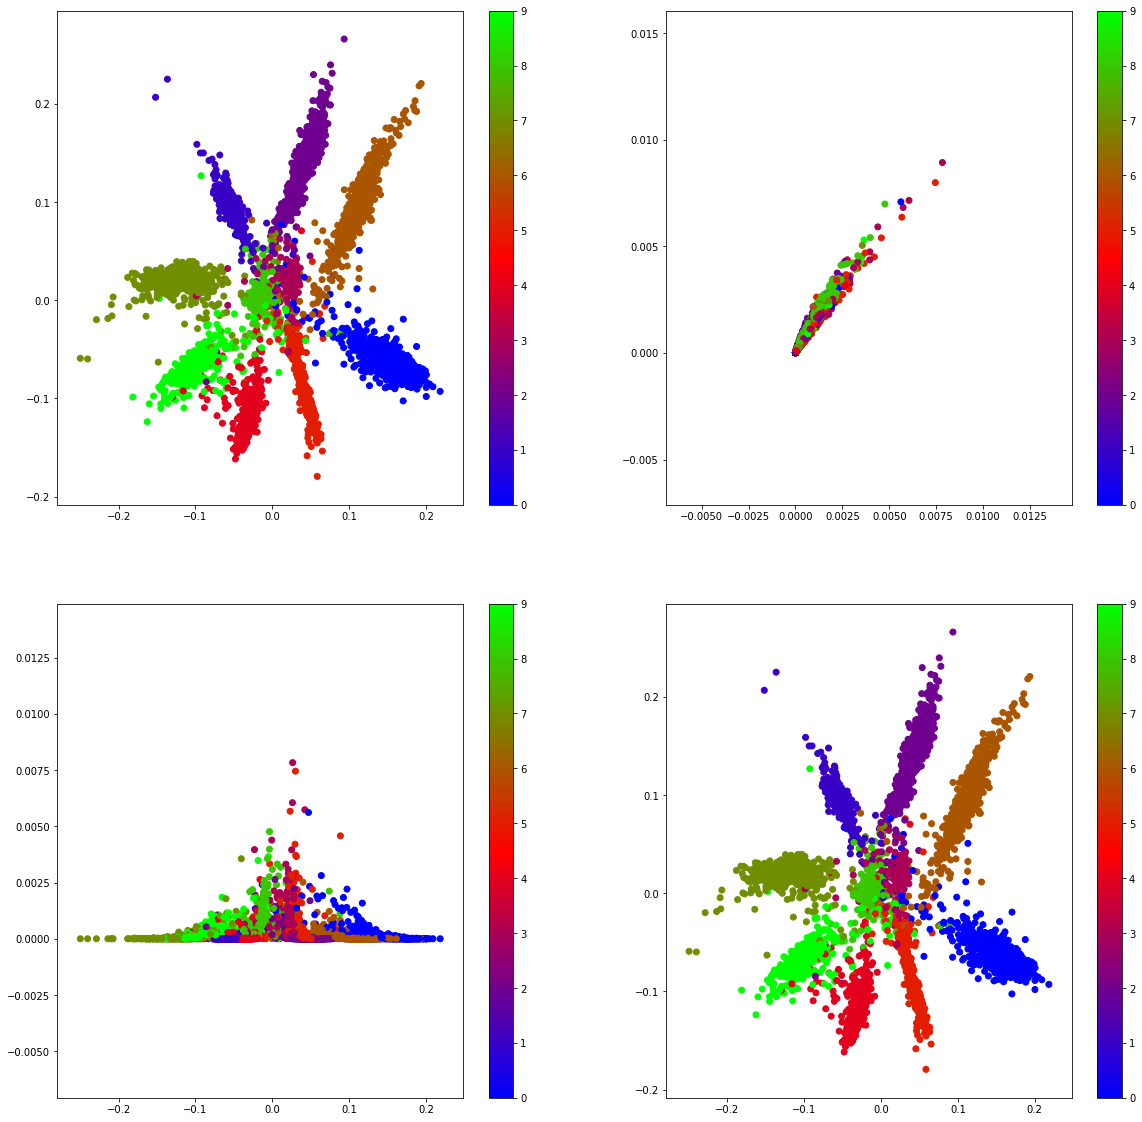

In [26]:
plot_2d_latent_space(model_supervised, onehot_encoder, X_test, y_test)

In [ ]:
model_supervised.get_cum_thetas()

In [340]:
resp_train = model_supervised.encode_to_discrete(X_train)
resp_test = model_supervised.encode_to_discrete(X_test)

In [372]:
resp_train.shape, resp_test.shape, X_train.shape

((63000, 10), (7000, 10), (63000, 784))

In [459]:
latent_train = model_supervised.sampleLatent(X_train)
latent_test = model_supervised.sampleLatent(X_test)

In [460]:
latent_train.shape

(63000, 2)

In [462]:
# simple_nn = SimpleNN([784,512,10])
# simple_nn.fit(X_train, y_train, X_test, y_test)

In [468]:
simple_nn = SimpleNN([10,512, 256, 128, 10])
simple_nn.fit(resp_train, y_train, resp_test, y_test, epochs=10)

Train accuracy: 86.57%
Test accuracy: 85.49%


In [466]:
simple_nn = SimpleNN([2,512, 256, 128, 10])
simple_nn.fit(latent_train, y_train, latent_test, y_test, epochs=10)

Train accuracy: 66.89%
Test accuracy: 66.24%


In [405]:
resp_train.shape

(63000, 10)

In [403]:
np.isnan(resp_train).sum(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [410]:
np.argwhere(np.isnan(resp_train))

array([], shape=(0, 2), dtype=int64)

In [409]:
resp_train[34097,:] = np.zeros(10)
resp_train[40214,:] = np.zeros(10)

In [414]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(resp_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [417]:
rf_predict = clf.predict(resp_test)

In [418]:
calculate_accuracy_np(y_pred=rf_predict, y_true=y_test)

0.6604285714285715

In [ ]:
np.argmax(resp_train, axis=1)

In [352]:
np.argmax(y_train, axis=1)

array([9, 1, 3, ..., 3, 1, 2])

In [354]:
reduced_data = pd.DataFrame({
    'in': np.argmax(resp_train, axis=1),
    'out': np.argmax(y_train, axis=1)
})

In [368]:
aaa = reduced_data[reduced_data['in']==6]

In [369]:
aaa.groupby(['out']).count()

,in
out,
1,1
2,3
3,13
4,468
5,12
6,6
7,50
8,22
9,5912


In [ ]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = StochasticNNWithGmm(
    x_dim=X_train.shape[1], 
    y_dim=y_train.shape[1], 
    hidden_dims=[512, 256, 128, 2], 
    log_folder=log_folder,
    alpha=1,
    beta=0,
    gamma=1,
    omega=0.00005,
    r=0.8,
    K=10,
    init_cov=init_cov,
    is_latent_supervised=False
)
model_supervised.fit(X_train, y_train, X_test, y_test, epochs=10, log_interval=100)

test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
print("Test accuracy {}".format(test_acc))